In [107]:
# simulated annealing code written by Nathan Rollins, modified to suit toxin antitoxin by David Ding. All credit goes to him!

In [1]:
from evcouplings.couplings import CouplingsModel
from evcouplings.couplings.model import _single_mutant_hamiltonians
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import viz_seqs
%matplotlib inline

dout = './out/'

In [2]:
def hamming(seq1,seq2):
    assert len(seq1) == len(seq2)
    h = 0
    for aa1,aa2 in zip(seq1,seq2):
        if aa1!=aa2:
            h+=1
    return h

class EVHannealer():
    '''optimize a focus sequence (uppercase only) according to statistical enery'''
    def __init__(self, model_file):
        self.model = CouplingsModel(model_file)
        self.L = len(self.model.index_list)
        self.AA = len(self.model.alphabet)
        
    def encode(self,seq):
        '''convert sequence to integer vector'''
        seq_vector = self.model.convert_sequences([seq])[0]
        return seq_vector
    
    def decode(self,seq_vector):
        '''convert integer vector to sequence'''
        seq = ''.join([self.model.alphabet[i] for i in seq_vector])
        return seq
    
    def random_seq_vector(self):
        seq_vector = np.array([np.random.choice(np.arange(len(self.model.alphabet)))
                               for i in range(len(self.model.target_seq))])
        return seq_vector
    
    def residuelist_to_mask(self,position_list,amino_acid_list):
        '''for listed positions, mask=1 for listed amino acid'''
        mask = np.zeros((self.L,self.AA))
        assert len(position_list) == len(amino_acid_list)
        for i,aa in zip(position_list,amino_acid_list):
            mask[self.model.index_map[i],self.model.alphabet_map[aa]] = 1.0
        return mask.astype(bool)
        
        
    def residuelist_to_negative_sitemask(self,position_list,amino_acid_list):
        '''for listed positions, mask=1 for amino acids mismatching listed amino acid'''
        mask = np.zeros((self.L,self.AA))
        assert len(position_list) == len(amino_acid_list)
        for i,aa in zip(position_list,amino_acid_list):
            mask[self.model.index_map[i],:] = 1.0
            mask[self.model.index_map[i],self.model.alphabet_map[aa]] = 0.0
        return mask.astype(bool)
    
    def get_hamming_matrix_fxn(self, target_focus_sequence, min_hamming, max_hamming, weight=10):
        '''create a fxn that favors match if hamming > max,
            penalizes match if hamming < min'''
        target_seq_vector = self.encode(target_focus_sequence)
        target_seq_mask = self.residuelist_to_mask(self.model.index_list,target_focus_sequence)
        penalty_well = lambda h: -weight*(h<=min_hamming) + weight*(h>=max_hamming)
        x = np.arange(min_hamming-5,max_hamming+5)
        plt.plot(x, np.vectorize(penalty_well)(x))
        plt.gcf().set_size_inches(3,3)
        
        mask_fxn = lambda seq_vector: (
            penalty_well(hamming(target_seq_vector, seq_vector))
            * target_seq_mask
            )
        return mask_fxn
        
        
    def mutate_seq(self, seq, residue_list, amino_acid_list):
        mseq = list(seq)
        for i,aa in zip(residue_list,amino_acid_list):
            mseq[self.model.index_map[i]] = aa
        return mseq
    
    def mutate_seq_vector(self, seq_vector, residue_list, amino_acid_list):
        mseq = deepcopy(seq_vector)
        for i,aa in zip(residue_list,amino_acid_list):
            mseq[self.model.index_map[i]] = self.model.alphabet_map[aa]
        return mseq
        
        
    def step(self,seq_vector,T,force_mutation=False,avoid_mask=None, penalty_matrix=None):
        '''introduce a mutation with boltzmann probability
        higher temperature = closer to uniform distribution'''
        EVH = _single_mutant_hamiltonians(seq_vector, self.model.J_ij, self.model.h_i)[:,:,0]
        E = deepcopy(EVH)
        if penalty_matrix is not None:
            E += penalty_matrix(seq_vector)
        
        P = np.exp(E/T)
        if avoid_mask is not None:
            P[avoid_mask(seq_vector)] = 0.0
    
        P = P/np.sum(P)
            
        P_flat = P.ravel()
        indices = np.arange(len(P_flat))
        mutation_index = np.random.choice(indices, p=P_flat)
        mutation_i, mutation_aa = np.unravel_index(mutation_index, P.shape)
        mut_vector = deepcopy(seq_vector)
        mut_vector[mutation_i] = mutation_aa
        mutation_EVH = EVH[mutation_i, mutation_aa]
        mutation_E = E[mutation_i, mutation_aa]
        previous_aa = seq_vector[mutation_i]

        return mut_vector, mutation_i, mutation_aa, previous_aa, mutation_EVH, mutation_E
        


In [3]:
model_dir = '/Users/davidding/Dropbox (HMS)/parESingleLibrary/ex22/naturalSequences/notebooks/'
annealer = EVHannealer(model_dir + "/parED_e1_3_m80_f80.model")

# load parameters from file to create a pairwise model
c = CouplingsModel(model_dir+"/parED_e1_3_m80_f80.model")

In [4]:
len(c.index_list)


160

In [5]:
len(c.seq())

160

In [6]:
list(c.index_list).index(181)

155

In [7]:
list(c.seq())[155]

'R'

In [8]:
c.seq(155)

'D'

In [9]:
l1= [1,2,3,4]
del l1[0]
l1

[2, 3, 4]

In [11]:
### muts_10x = 'L48L:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R'

fixed_pos = list(c.index_list)
fixed_wt_aa = list(c.seq())

offset = 103

wt_muts = 'L48L:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R'


idxs_to_remove = [] # make a list of indices to be removed from the fixed position list of uppercase indices and wt_aa to be fixed.
for m in wt_muts.split(':'):
    wt_aa = m[0]
    mut_pos = int(m[1:-1])
    mut_aa = m[-1]
    
    complex_mut_pos = offset + mut_pos
    print(m, complex_mut_pos)
    if complex_mut_pos in c.index_list:
        assert wt_aa == c.seq(complex_mut_pos) 
        
        to_remove_idx = list(c.index_list).index(complex_mut_pos)
        idxs_to_remove.append(to_remove_idx)
        
        print(to_remove_idx)
        
    else:
        print(m, 'not uppercase in couplingsmodel')

fixed_pos = [i for j, i in enumerate(fixed_pos) if j not in idxs_to_remove]
fixed_wt_aa = [i for j, i in enumerate(fixed_wt_aa) if j not in idxs_to_remove]

assert len(fixed_pos) == len(fixed_wt_aa)

print(len(fixed_pos))

# fix all non-mutated positions apart from AT L48, which is lowercase (not enough column coverage)
fixed_position_mask = annealer.residuelist_to_negative_sitemask(
    fixed_pos,fixed_wt_aa
)


L48L 151
L48L not uppercase in couplingsmodel
D52D 155
129
I53I 156
130
R55R 158
132
L56L 159
133
F74F 177
151
R78R 181
155
E80E 183
157
A81A 184
158
R82R 185
159
151


In [12]:

def make_annealed_samples(t_correction, distance_penalty):
    # Start with a random sequence
    start_seq_vector = annealer.random_seq_vector()
    sample_seq_vector = deepcopy(start_seq_vector)
    # Set any fixed positions to fixed AA values
    sample_seq_vector = annealer.mutate_seq_vector(
        sample_seq_vector,fixed_pos,fixed_wt_aa
    )

    # Set temperature cycle for annealing
    L = int(len(start_seq_vector))
    T_cycle = [1.0*t_correction]*L + [0.5*t_correction]*L + [0.2*t_correction]*L

    # Record progress during annealing
    annealing_report = []
    for n,T in enumerate(T_cycle):
        sample_seq_vector, mut_i, mut_aa, prev_aa, mut_EVH, mut_E = annealer.step(
            sample_seq_vector,
            T,
            penalty_matrix = distance_penalty,
            avoid_mask = lambda x: fixed_position_mask
        )

        annealing_report.append([sample_seq_vector, mut_i, mut_aa, prev_aa, mut_EVH, mut_E])

    # Make progress report human-readable
    annealing_report = pd.DataFrame(annealing_report, columns=['seq_vector','n_i','n_aa_mut','n_aa_prev','delta_EVH','delta_E'])
    annealing_report.loc[:,'i'] = annealing_report.n_i.apply(lambda n: annealer.model.index_list[n])
    annealing_report.loc[:,'aa_prev'] = annealing_report.n_aa_prev.apply(lambda n: annealer.model.alphabet[n])
    annealing_report.loc[:,'aa_mut'] = annealing_report.n_aa_mut.apply(lambda n: annealer.model.alphabet[n])

    # Calculate EVH scores (annealer returns delta EVHs)
    target_seq = annealer.model.target_seq
    scores = annealer.model.hamiltonians(np.array(list(annealing_report.seq_vector)))
    annealing_report.loc[:,'E']  = scores[:,0]
    annealing_report.loc[:,'Eh'] = scores[:,1]
    annealing_report.loc[:,'Ej'] = scores[:,2]
    annealing_report.loc[:,'E-Ewt'] = annealing_report['E'] - annealer.model.hamiltonians([target_seq])[0,0]

    # Compare sequences to EVH model target sequence
    annealing_report.loc[:,'seq'] = annealing_report.seq_vector.apply(annealer.decode)
    annealing_report.loc[:,'Nmuts'] = annealing_report.seq.apply(lambda x: sum(a!=b for a,b in zip(target_seq,x)))


    wt_seq = ''.join(c.seq())

    def get_muts(mut_seq):
        mut_str = ':'.join([v_wt +str(pos-offset)+ v_mut for pos,v_wt, v_mut in zip(c.index_list, c.seq(), mut_seq) if v_wt != v_mut])
        return mut_str

    annealing_report['muts'] = annealing_report.apply(lambda r: get_muts(r.seq), axis=1)


    wt_muts = 'L48L:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R'

    def make_full_mut(wt_muts, mut_muts):
        # expecting something like mut_muts = 'D52E:I53V:F74M:R78K'
        # and wt_muts = 'L48L:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R'
        # and make the full wt muts
        dic_wt_muts = dict(
            zip([v[:-1] for v in wt_muts.split(':')],
                wt_muts.split(':')
               )
                 )
        dic_mut_muts = dict(
            zip([v[:-1] for v in mut_muts.split(':')],
                mut_muts.split(':')
               )
                 )

        full_muts = []
        for k,v in dic_wt_muts.items():
            if k in dic_mut_muts:
                full_muts.append(dic_mut_muts[k])
            else:
                full_muts.append(v)

        return ':'.join(full_muts)

    annealing_report['full_mut'] = annealing_report.apply(lambda r: make_full_mut(wt_muts, r.muts), axis=1)


    # Preview the table
    #annealing_report.iloc[[0,1,2,-3,-2,-1]]
    return annealing_report


In [16]:
for t in [1e-2, 1e-1, 1, 2,3,5,10]:
    df_anneal_t = make_annealed_samples(t, distance_penalty=None)
    df_anneal_t.to_csv(dout+ 't_screen/' + 'df_anneal_{}.csv'.format(t))



/Users/davidding/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: overflow encountered in exp


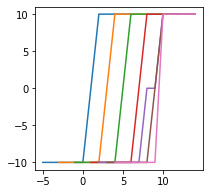

In [104]:

# create a distance penalty
dp_0_2_10 = annealer.get_hamming_matrix_fxn(
    annealer.model.target_seq, 0, 2, weight=10
)
df_anneal_02 = make_annealed_samples(1, dp_0_2_10)

# create a distance penalty
dp_2_4_10 = annealer.get_hamming_matrix_fxn(
    annealer.model.target_seq, 2, 4, weight=10
)
df_anneal_24 = make_annealed_samples(1, dp_2_4_10)

# create a distance penalty
dp_4_6_10 = annealer.get_hamming_matrix_fxn(
    annealer.model.target_seq, 4, 6, weight=10
)
df_anneal_46 = make_annealed_samples(1, dp_4_6_10)

# create a distance penalty
dp_6_8_10 = annealer.get_hamming_matrix_fxn(
    annealer.model.target_seq, 6, 8, weight=10
)
df_anneal_68 = make_annealed_samples(1, dp_6_8_10)

# create a distance penalty
dp_7_10_10 = annealer.get_hamming_matrix_fxn(
    annealer.model.target_seq, 7, 10, weight=10
)
df_anneal_710 = make_annealed_samples(1, dp_7_10_10)


# create a distance penalty
dp_8_10_10 = annealer.get_hamming_matrix_fxn(
    annealer.model.target_seq, 8, 10, weight=10
)
df_anneal_810 = make_annealed_samples(1, dp_8_10_10)

# create a distance penalty
dp_9_10_10 = annealer.get_hamming_matrix_fxn(
    annealer.model.target_seq, 9, 10, weight=10
)
df_anneal_910 = make_annealed_samples(1, dp_9_10_10)


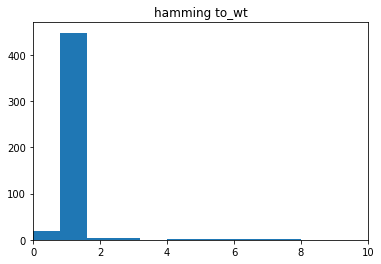

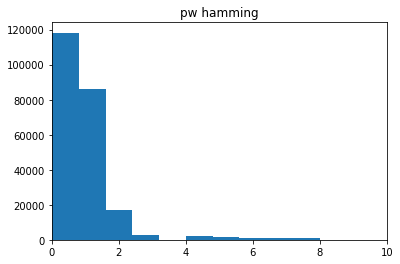

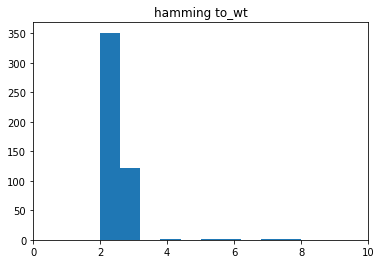

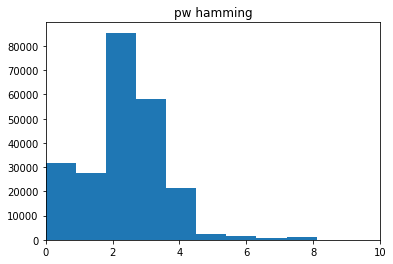

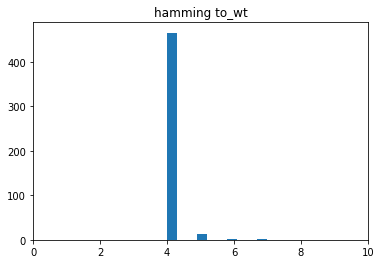

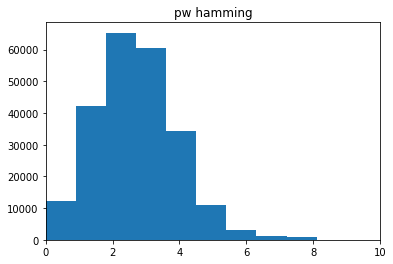

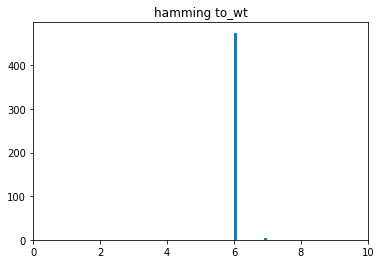

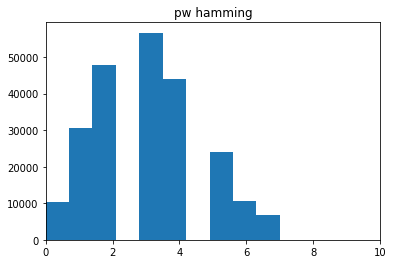

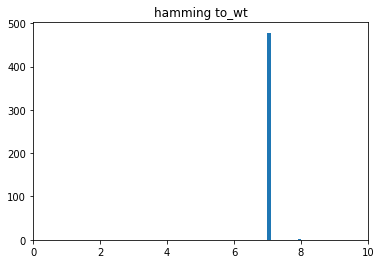

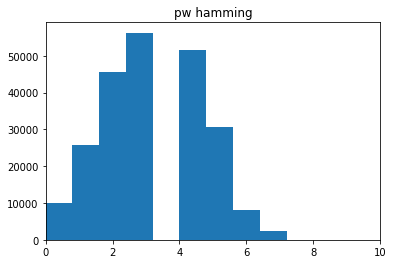

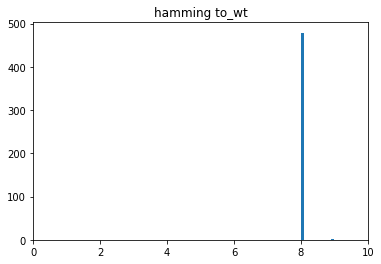

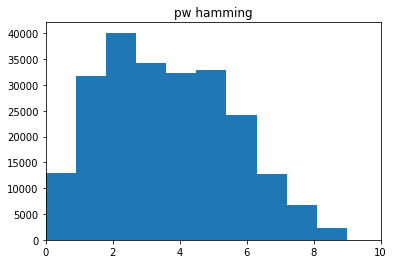

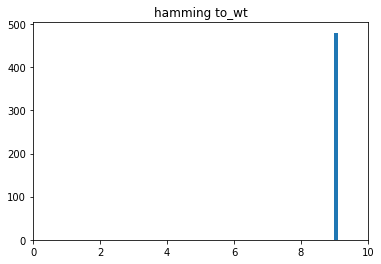

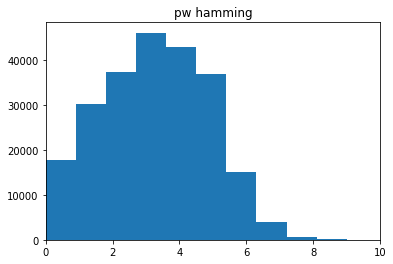

In [105]:
def plot_hist_hammings(df):
    # plot hamming_distance to wt
    
    plt.figure()
    plt.xlim([0,10])
    plt.hist(df.Nmuts)
    plt.title('hamming to_wt')
    plt.show()
    
    # plot hamming_distance between each other:
    
    list_pw_hamming =[]
    for m1 in df.full_mut:
        for m2 in df.full_mut:
            list_pw_hamming.append(hamming(m1, m2))
    plt.figure()
    plt.xlim([0,10])
    plt.hist(list_pw_hamming)
    plt.title('pw hamming')
    plt.show()
plot_hist_hammings(df_anneal_02)
plot_hist_hammings(df_anneal_24)
plot_hist_hammings(df_anneal_46)
plot_hist_hammings(df_anneal_68)
plot_hist_hammings(df_anneal_710)
plot_hist_hammings(df_anneal_810)
plot_hist_hammings(df_anneal_910)


In [108]:
df_anneal_02.to_csv(dout + 'df_anneal_02.csv')
df_anneal_24.to_csv(dout + 'df_anneal_24.csv')

df_anneal_46.to_csv(dout + 'df_anneal_46.csv')

df_anneal_68.to_csv(dout + 'df_anneal_68.csv')

df_anneal_710.to_csv(dout + 'df_anneal_710.csv')

df_anneal_810.to_csv(dout + 'df_anneal_810.csv')
df_anneal_910.to_csv(dout + 'df_anneal_910.csv')


## nathan's code

In [3]:
annealer = EVHannealer('IGHG1_HUMAN_221_341_b0.8.model')

### Penalize sequences outside of target distance range

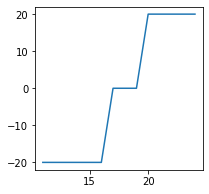

In [4]:
distance_penalty = annealer.get_hamming_matrix_fxn(
    annealer.model.target_seq, 16, 20, weight=20
)

### Fix selected sites to given amino acid

In [5]:
fixed_idxs = [297,322]
fixed_aas  = ['A','A']

fixed_position_mask = annealer.residuelist_to_negative_sitemask(
    fixed_idxs,fixed_aas
)
# fix N297A, K322A

Best if you also initialize your random sequences with the selected sites already assigned to the given amino acid.

## Run annealing

In [7]:
# Start with a random sequence
start_seq_vector = annealer.random_seq_vector()
sample_seq_vector = deepcopy(start_seq_vector)
# Set any fixed positions to fixed AA values
sample_seq_vector = annealer.mutate_seq_vector(
    sample_seq_vector,fixed_idxs,fixed_aas
)

# Set temperature cycle for annealing
L = len(start_seq_vector)
T_cycle = [1.0]*L + [0.5]*L + [0.2]*L

# Record progress during annealing
annealing_report = []
for n,T in enumerate(T_cycle):
    sample_seq_vector, mut_i, mut_aa, prev_aa, mut_EVH, mut_E = annealer.step(
        sample_seq_vector,
        T,
        penalty_matrix = distance_penalty,
        avoid_mask = lambda x: fixed_position_mask
    )
    
    annealing_report.append([sample_seq_vector, mut_i, mut_aa, prev_aa, mut_EVH, mut_E])

## Tabulate report

In [8]:
# Make progress report human-readable
annealing_report = pd.DataFrame(annealing_report, columns=['seq_vector','n_i','n_aa_mut','n_aa_prev','delta_EVH','delta_E'])
annealing_report.loc[:,'i'] = annealing_report.n_i.apply(lambda n: annealer.model.index_list[n])
annealing_report.loc[:,'aa_prev'] = annealing_report.n_aa_prev.apply(lambda n: annealer.model.alphabet[n])
annealing_report.loc[:,'aa_mut'] = annealing_report.n_aa_mut.apply(lambda n: annealer.model.alphabet[n])

# Calculate EVH scores (annealer returns delta EVHs)
target_seq = annealer.model.target_seq
scores = annealer.model.hamiltonians(np.array(list(annealing_report.seq_vector)))
annealing_report.loc[:,'E']  = scores[:,0]
annealing_report.loc[:,'Eh'] = scores[:,1]
annealing_report.loc[:,'Ej'] = scores[:,2]
annealing_report.loc[:,'E-Ewt'] = annealing_report['E'] - annealer.model.hamiltonians([target_seq])[0,0]

# Compare sequences to EVH model target sequence
annealing_report.loc[:,'seq'] = annealing_report.seq_vector.apply(annealer.decode)
annealing_report.loc[:,'Nmuts'] = annealing_report.seq.apply(lambda x: sum(a!=b for a,b in zip(target_seq,x)))

# Preview the table
annealing_report.iloc[[0,1,2,-3,-2,-1]]

,seq_vector,n_i,n_aa_mut,n_aa_prev,delta_EVH,delta_E,i,aa_prev,aa_mut,E,Eh,Ej,E-Ewt,seq,Nmuts
0,"[5, 10, 3, 8, 15, 17, 15, 13, 0, 6, 11, 12, 13...",86,18,0,8.472644,28.472644,313,A,W,61.032096,0.702062,60.330034,-578.332462,GMEKSVSQAHNPQVHLFQGKSDPILYCSSTFVDCLTQLYNAPWHEK...,103
1,"[5, 10, 3, 8, 15, 17, 15, 13, 0, 6, 11, 12, 13...",81,17,15,7.618960,27.618960,308,S,V,68.651056,0.672541,67.978515,-570.713502,GMEKSVSQAHNPQVHLFQGKSDPILYCSSTFVDCLTQLYNAPWHEK...,102
2,"[5, 10, 3, 8, 15, 17, 15, 13, 0, 6, 11, 12, 13...",33,16,1,8.124559,28.124559,260,C,T,76.775614,0.728769,76.046846,-562.588943,GMEKSVSQAHNPQVHLFQGKSDPILYCSSTFVDTLTQLYNAPWHEK...,101
339,"[12, 8, 1, 12, 0, 12, 3, 9, 9, 5, 5, 12, 15, 1...",70,0,0,0.000000,0.000000,297,A,A,638.630857,65.431551,573.199306,-0.733701,PKCPAPELLGGPSVFIFPPKPKDTLMISRTPEVTCVVVDVGQDDPE...,18
340,"[12, 8, 1, 12, 0, 12, 3, 9, 9, 5, 5, 12, 15, 1...",91,3,3,0.000000,0.000000,318,E,E,638.630857,65.431551,573.199306,-0.733701,PKCPAPELLGGPSVFIFPPKPKDTLMISRTPEVTCVVVDVGQDDPE...,18
341,"[12, 8, 1, 12, 0, 12, 3, 9, 9, 5, 5, 12, 15, 1...",92,4,4,0.000000,0.000000,319,F,F,638.630857,65.431551,573.199306,-0.733701,PKCPAPELLGGPSVFIFPPKPKDTLMISRTPEVTCVVVDVGQDDPE...,18


## How efficiently did the EVH scores converge?

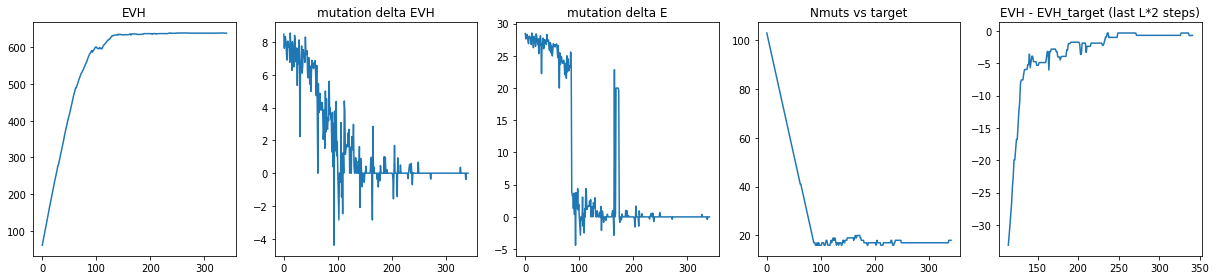

In [9]:
f,ax=plt.subplots(1,5,figsize=(17,4))
ax[0].plot(annealing_report['E'])
ax[1].plot(annealing_report['delta_EVH'])
ax[2].plot(annealing_report['delta_E'])
ax[3].plot(annealing_report['Nmuts'])
ax[4].plot(annealing_report['E-Ewt'][-L*2:])
for i,title in enumerate(['EVH','mutation delta EVH','mutation delta E',
                          'Nmuts vs target','EVH - EVH_target (last L*2 steps)']):
    ax[i].set_title(title)
f.tight_layout()

## Where are my mutations?

In [10]:
h = hamming(annealer.model.target_seq,annealing_report.seq.iloc[-1])

print('final sampled sequence hamming:',h)

viz_seqs.viz_compare_seqs(
    annealing_report.seq.iloc[-1], ''.join(target_seq)
);

final sampled sequence hamming: 18
PKCPAPELLGGPSVFIFPPKPKDTLMISRTPEVTCVVVDVGQDDPEVQFSWYVDGVEVHTAKTKPREEQFASTYR
| ||||||||||||| ||||||||||||||||||||||||   |||| | ||||||||| |||||||||  ||||
PPCPAPELLGGPSVFLFPPKPKDTLMISRTPEVTCVVVDVSHEDPEVKFNWYVDGVEVHNAKTKPREEQYNSTYR
 *             *                        ***    * *         *         **    


VVSVLPIQHQDWLKGKEFKCAVNNKALPAPIERTISKAK                                    
|||||   ||||| ||| || | ||||||||| ||||||                                    
VVSVLTVLHQDWLNGKEYKCKVSNKALPAPIEKTISKAK                                    
     ***     *   *  * *         *                                          




## How effective are my mutations?

In [12]:
def get_mutation_report(
    annealer, target_sequence, design_sequence
):
    vec_i,vec_wt,vec_aa = [],[],[]
    seq_i,seq_wt,seq_aa = [],[],[]
    assert len(target_sequence) == len(design_sequence)
    for i, (aa_wt, aa_des) in enumerate(zip(target_sequence, design_sequence)):
        if aa_wt == aa_des:
            continue
        vec_i.append(i)
        seq_wt.append(aa_wt)
        seq_aa.append(aa_des)
        seq_i.append(annealer.model.index_list[i])
        vec_wt.append(annealer.model.alphabet_map[aa_wt])
        vec_aa.append(annealer.model.alphabet_map[aa_des])
    
    evh_wt_context = []
    evh_des_context = []
    target_mut_mat = _single_mutant_hamiltonians(
        annealer.encode(target_sequence), annealer.model.J_ij, annealer.model.h_i)
    design_mut_mat = _single_mutant_hamiltonians(
        annealer.encode(design_sequence), annealer.model.J_ij, annealer.model.h_i)
    for n in range(len(vec_i)):
        evh_wt_context.append(
            target_mut_mat[vec_i[n],vec_aa[n],0])
        evh_des_context.append(
            -design_mut_mat[vec_i[n],vec_wt[n],0])
    return seq_i,seq_wt,seq_aa,evh_wt_context,evh_des_context,target_mut_mat,design_mut_mat

def plot_mutation_report(annealer,target_sequence,design_sequence, fixed_sites=[]):
    seq_i,seq_wt,seq_aa,evh_wt_context,evh_des_context,target_mut_mat,design_mut_mat = \
        get_mutation_report(annealer, target_sequence, design_sequence)
    
    f,ax=plt.subplots(1,3,figsize=(20,6))
    bins = ax[0].hist(target_mut_mat.flatten(), alpha=0.5, density=True);
    ax[0].hist(evh_wt_context, bins=bins[1], alpha=0.5, density=True);
    bins = ax[1].hist(design_mut_mat.flatten(), alpha=0.5, density=True);
    ax[1].hist(evh_des_context, bins=bins[1], alpha=0.5, density=True);
    x,y =target_mut_mat.flatten(),design_mut_mat.flatten()
    ax[2].scatter(x[(x!=0) & (y!=0)],y[(x!=0) & (y!=0)],c='gray',alpha=0.1)
    ax[2].scatter(evh_wt_context, evh_des_context)
    leg = ['all non-target/design subs', 'subs in design']
    if len(fixed_sites) > 0:
        vec_sites = [annealer.model.index_map[i] for i in fixed_sites]
        x,y=target_mut_mat[vec_sites].flatten(),design_mut_mat[vec_sites].flatten()
        ax[2].scatter(x[(x!=0) & (y!=0)],y[(x!=0) & (y!=0)],c='red', alpha=0.25)
        leg.append('alt. subs @ fixed idxs')
    ax[2].legend(leg,loc=4)
    x0,x1 = np.min(evh_wt_context), np.max(evh_wt_context)
    ax[2].plot([x0,x1],[x0,x1],c='k')
    ax[0].set_title('individual substitutions in wt context')
    ax[1].set_title('individual substitutions in design context')
    ax[2].set_title('wt context (x-axis) versus design context (y-axis)')
    
    return seq_i,seq_wt,seq_aa,evh_wt_context,evh_des_context,target_mut_mat,design_mut_mat

['P228K', 'L242I', 'S267G', 'H268Q', 'E269D', 'K274Q', 'N276S', 'N286T', 'Y296F', 'N297A', 'T307P', 'V308I', 'L309Q', 'N315K', 'Y319F', 'K322A', 'S324N', 'K334R']


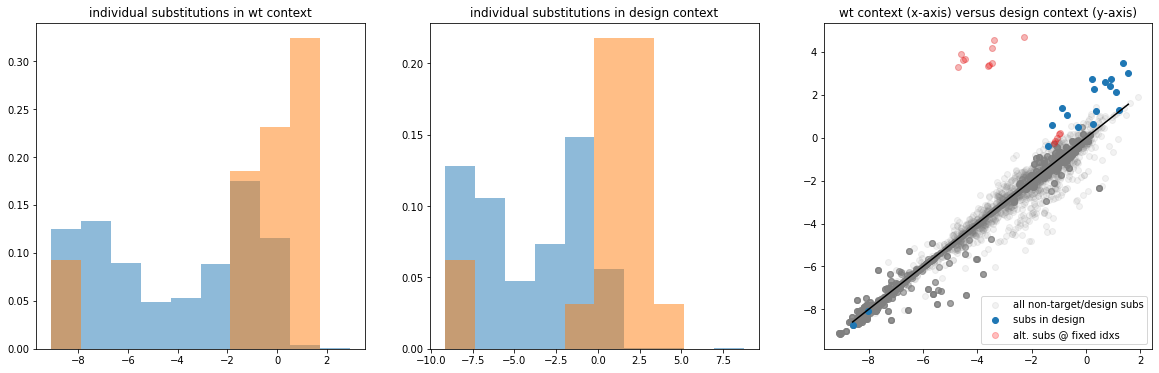

In [13]:
q = plot_mutation_report(
    annealer,annealer.model.target_seq,annealing_report.seq.iloc[-1],
    fixed_idxs)
print([f'{w}{i}{a}' for w,i,a in zip(q[1],q[0],q[2])])

In this instance, the 2 poorly scoring mutations are those we fixed in place

We see the substitutions are slightly more favorable in design context.